# 80 · Vision Forgery Detection
        
        Train/evaluate a simple vision classifier for document/image forgery.
        - Point to the Intel image dataset downloaded via KaggleHub.
        - Inspect classes and a few sample images.
        - Fine-tune a small backbone (simple CNN or ResNet) and plot metrics.


In [ ]:
# Helper: clean DataFrame to avoid missing-column/NaN errors
import pandas as pd

def clean_frame(df, target=None, numeric_expected=None, categorical_expected=None):
    df = df.loc[:, ~df.columns.str.startswith('Unnamed')]
    df = df.dropna(axis=1, how='all').copy()
    numeric_expected = numeric_expected or []
    categorical_expected = categorical_expected or []
    for col in numeric_expected:
        if col not in df.columns:
            df[col] = 0.0
    for col in categorical_expected:
        if col not in df.columns:
            df[col] = 'missing'
    num_cols = df.select_dtypes(include=['number']).columns
    cat_cols = df.select_dtypes(exclude=['number']).columns
    if len(num_cols):
        df[num_cols] = df[num_cols].fillna(df[num_cols].median())
    if len(cat_cols):
        df[cat_cols] = df[cat_cols].fillna('missing')
    if target:
        if target not in df.columns:
            raise KeyError(f"Target '{target}' missing. Columns: {df.columns.tolist()}")
        df[target] = pd.to_numeric(df[target], errors='coerce').fillna(0).astype(int)
    return df


In [1]:
from pathlib import Path
import sys, random
import matplotlib.pyplot as plt
from PIL import Image

project_root = Path('..').resolve()
src_path = project_root / 'src'
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

from uais.vision.train_vision_model import VisionConfig, run_vision_experiment

# Default to Intel image classification dataset pulled via KaggleHub
data_dir = project_root / 'data' / 'raw' / 'vision' / 'datasets' / 'puneet6060' / 'intel-image-classification' / 'versions' / '2' / 'seg_train'
print('Data dir:', data_dir, '| exists:', data_dir.exists())


: 

In [ ]:
# Optional: load tabular vision metadata (CSV/Parquet) if available under data/raw/vision
from uais.data.load_datasets import load_vision_data
try:
    vision_tabular = load_vision_data()
    print('Loaded vision tabular data:', vision_tabular.shape)
except Exception as exc:
    print('Vision tabular load skipped:', exc)


In [ ]:
if 'vision_tabular' in locals():
    vision_tabular = clean_frame(vision_tabular)
    print('Cleaned vision tabular:', vision_tabular.shape)


Classes: ['seg_train']
Counts per class: {'seg_train': 6}


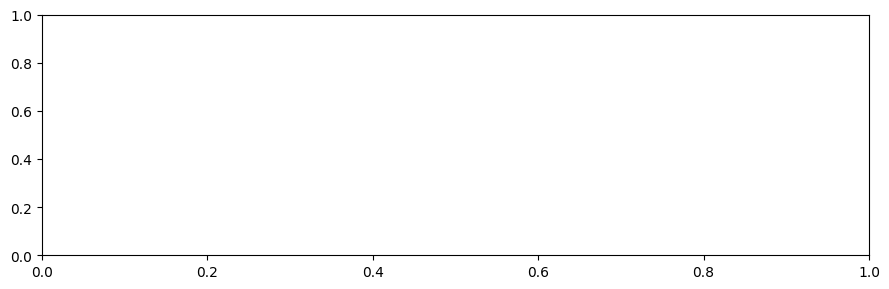

In [ ]:
# Inspect classes and show sample images
if not data_dir.exists():
    raise FileNotFoundError(f'Missing dataset directory: {data_dir}')
class_dirs = sorted([d for d in data_dir.iterdir() if d.is_dir()])
print('Classes:', [d.name for d in class_dirs])
counts = {d.name: len(list(d.glob('*'))) for d in class_dirs}
print('Counts per class:', counts)

fig, axes = plt.subplots(1, min(3, len(class_dirs)), figsize=(9,3))
if len(class_dirs) == 1:
    axes = [axes]
for ax, d in zip(axes, class_dirs):
    imgs = list(d.glob('*.jpg')) + list(d.glob('*.png'))
    if not imgs:
        continue
    img = Image.open(random.choice(imgs)).convert('RGB')
    ax.imshow(img)
    ax.set_title(d.name)
    ax.axis('off')
plt.tight_layout(); plt.show()


## Data cleaning
Verify image files and flag non-image/corrupted entries before training.

In [ ]:
import imghdr
from collections import Counter

bad_files = []
ext_counts = Counter()
for img_path in data_dir.rglob('*'):
    if not img_path.is_file():
        continue
    kind = imghdr.what(img_path)
    ext = img_path.suffix.lower()
    if kind is None:
        bad_files.append(img_path)
    else:
        ext_counts[ext] += 1

print('Image extension counts:', dict(ext_counts))
print('Non-image/corrupt files:', len(bad_files))
if bad_files:
    print('Examples:', bad_files[:5])


Found 14034 files belonging to 1 classes.
Using 11228 files for training.
Found 14034 files belonging to 1 classes.
Using 2806 files for validation.
Epoch 1/3


/Users/pratik_n/Desktop/MyComputer/universal-anomaly-intelligence/.venv-macos/lib/python3.13/site-packages/keras/src/ops/nn.py:946: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


351/351 ━━━━━━━━━━━━━━━━━━━━ 221s 625ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/3
351/351 ━━━━━━━━━━━━━━━━━━━━ 219s 624ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/3
351/351 ━━━━━━━━━━━━━━━━━━━━ 216s 614ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Validation metrics: {'val_loss': 0.0, 'val_accuracy': 0.0}


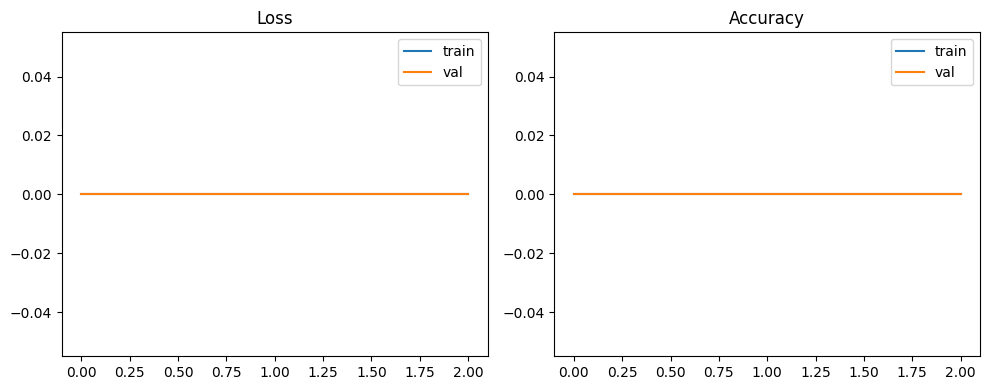

In [ ]:
# Train/evaluate vision model
config = VisionConfig(
    dataset_dir=data_dir,
    image_size=224,
    batch_size=32,
    epochs=3,
    backbone='resnet18',
)
metrics = run_vision_experiment(config)
print('Validation metrics:', {k: v for k,v in metrics.items() if k != 'history'})

hist = metrics.get('history', {})
if hist:
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    ax[0].plot(hist.get('loss', []), label='train')
    ax[0].plot(hist.get('val_loss', []), label='val')
    ax[0].set_title('Loss'); ax[0].legend()
    ax[1].plot(hist.get('accuracy', []), label='train')
    ax[1].plot(hist.get('val_accuracy', []), label='val')
    ax[1].set_title('Accuracy'); ax[1].legend()
    plt.tight_layout(); plt.show()
